In [2]:
from typing import List, Union
from tqdm import tqdm
import string
import datetime
from dateutil import parser
import multiprocessing as mp

import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split


import pyarrow as pa
import pyarrow.dataset as ds



/Users/luis.morales/Desktop/MLOpsBootcamp/MLOpsCapstoneProject/mlopsenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Cleaning Utilities

In [15]:
def change_date_type(dates: Union[pd.DataFrame, pd.Series]) -> List:
    """
    Formats string column into datetime object
    """
    column = []
    
    for date in dates:
        column.append(parser.parse(date).strftime("%d-%m-%Y %H:%M:%S"))
    
    series = pd.Series(column)
    return pd.to_datetime(series)


def str_to_list(row):
    """convert a string List into a List"""
    row = str(row).strip("[]").replace("'","")
    return row


def parsed_email_processing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Basic email formatting and cleaning
    """
    
    df['Date'] = change_date_type(df['Date'])
    
    df['body'] = df['body'].str.replace('\n','').str.replace('\t','')
    
    df['To'] = df['To'].astype('str')\
        .str.replace('b','')\
        .apply(str_to_list)
        
    df['From'] = df['From'].astype('str')\
        .str.replace('b','')\
        .apply(str_to_list)
    
    return df    

### Text Normalization Utilities

In [3]:
def spacy_normalization_process(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
    print("Tokenize+Lemmatize:")
    print(lemma_list)
    
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    
    #Remove punctuation
    punctuations="?:!.,;"
    for word in filtered_sentence:
        if word in punctuations:
            filtered_sentence.remove(word)
    
    return filtered_sentence

In [4]:
nlp = spacy.load("en_core_web_sm")
# stops = stopwords.words("english")
import nltk
nltk.download('stopwords')

def _normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)


# result = test['body'].apply(_normalize, lowercase=True, remove_stopwords=True).to_frame()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luis.morales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
nlp = spacy.load("en_core_web_sm")

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 nlp = nlp,
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Punctuation removal
            2. Stop words removal
            3. Lemmatization

        nlp  - spacy model
        n_jobs - parallel jobs to run
        """
        self.nlp = nlp
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data
    
    
    def _remove_punct(self, doc):
        return (t for t in doc if t.text not in string.punctuation)
    

    def _remove_stop_words(self, doc):
        return (t for t in doc if not t.is_stop)
    

    def _lemmatize(self, doc):
        return ' '.join(t.lemma_ for t in doc)
    

    def _preprocess_text(self, text):
        doc = self.nlp(text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)
    
    
    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

### Text features

#### Spam and Ham reduced set

In [13]:
not_spam_reduced_df = pd.read_parquet('../data/sagemaker-testing/Parsed/not_spam.parquet.gzip')
spam_reduced_df = pd.read_parquet('../data/sagemaker-testing/Parsed/spam.parquet.gzip')

In [19]:
not_spam_reduced_df['spam'] = 0
spam_reduced_df['spam'] = 1

In [20]:
reduced_df = parsed_email_processing(pd.concat([spam_reduced_df, not_spam_reduced_df]).reset_index(drop=True))

In [21]:
nlp = spacy.load("en_core_web_sm")
Normalizer = TextPreprocessor(nlp, -1)
reduced_df['body_transformed'] = Normalizer.transform(reduced_df['body'])

In [25]:
reduced_df.to_csv('../data/sagemaker-testing/Parsed/reduced_email.csv', index=False)

#### Spam and Ham Complete set

In [ ]:
# not_spam_df = pd.read_parquet('../data/labeled_data/nonspam.parquet.gzip')
# spam_df = pd.read_parquet('../data/labeled_data/spam.parquet.gzip')

In [ ]:
# complete_df = pd.concat([spam_df, not_spam_df]).reset_index(drop=True)

In [ ]:
# complete_df.to_parquet('../data/labeled_data/labeled_data_v0.parquet.gzip', compression='gzip', engine='fastparquet')
# complete_df.to_csv('../data/labeled_data/labeled_data_v0.csv', index=False)

In [ ]:
# complete_df = parsed_email_processing(complete_df)

In [4]:
complete_df = pd.read_csv('../data/labeled_data/labeled_data_v0.csv')

In [5]:
complete_df.head()

,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,spam,body_transformed
0,<8307461.1075860887277.JavaMail.evans@thyme>,2004-03-02 18:14:47,"[""hotwecash@lists.adversend.com""]","[""m..presto@enron.com""]",Free Grants For Those In Need!,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,HotWebCash Newsletter <hotwebcash@lists.advers...,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Kevin_Presto_Mar2002_1\Presto, Kevin M.\Junk ...",Presto-K,kpresto (Non-Privileged).pst,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $Have...,1,hotwebcash turn receive loan bank poor credit ...
1,<31088330.1075860887438.JavaMail.evans@thyme>,2004-03-02 18:14:47,"[""hotwecash@lists.adversend.com""]","[""m..presto@enron.com""]",Your Opinion Counts...Win $1000!,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,HotWebCash Newsletter <hotwebcash@lists.advers...,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Kevin_Presto_Mar2002_1\Presto, Kevin M.\Junk ...",Presto-K,kpresto (Non-Privileged).pst,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $Your...,1,hotwebcash opinion count ... reward It!Join NP...
2,<8829953.1075860887541.JavaMail.evans@thyme>,2004-03-02 18:14:47,"[""hotwecash@lists.adversend.com""]","[""m..presto@enron.com""]",LOSE POUNDS GUARANTEED!,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,HotWebCash Newsletter <hotwebcash@lists.advers...,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Kevin_Presto_Mar2002_1\Presto, Kevin M.\Junk ...",Presto-K,kpresto (Non-Privileged).pst,$ * $ * $ * $ * $ HOTWEBCASH $ * $ * $ * $ * $...,1,hotwebcash program tailor specific needs!eat F...
3,<25503194.1075860887462.JavaMail.evans@thyme>,2004-03-02 18:14:47,"[""hotwecash@lists.adversend.com""]","[""m..presto@enron.com""]",Someone is searching for YOU!,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,HotWebCash Newsletter <hotwebcash@lists.advers...,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Kevin_Presto_Mar2002_1\Presto, Kevin M.\Junk ...",Presto-K,kpresto (Non-Privileged).pst,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $Find...,1,hotwebcash find match ... Click http://r1.adve...
4,<3520246.1075860887301.JavaMail.evans@thyme>,2004-03-02 18:14:47,"[""hotwecash@lists.adversend.com""]","[""m..presto@enron.com""]","Take a Survey, Win a FREE New Computer!!",NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,HotWebCash Newsletter <hotwebcash@lists.advers...,"Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Kevin_Presto_Mar2002_1\Presto, Kevin M.\Junk ...",Presto-K,kpresto (Non-Privileged).pst,$ * $ * $ * $ * HOTWEBCASH * $ * $ * $ * $Comp...,1,hotwebcash complete short survey automatically...


In [14]:
# complete_df[complete_df['spam'] == 0]['body_transformed'].to_list()

In [ ]:
nlp = spacy.load("en_core_web_sm")
Normalizer = TextPreprocessor(nlp, -1)
complete_df['body_transformed'] = Normalizer.transform(complete_df['body'])

In [ ]:
complete_df[complete_df['spam'] == 0]['body'].to_list()[1]

'OUTLOOK EMAIL NOTIFICATIONYour Date of Migration is: May 10thYOU WILL BE UNABLE TO SEND E-MAIL unless you take the following action:Please go through your Notes email and clean out as many old/un-needed emai=l=20items as possible BEFORE your date of migration.? After you are migrated to==20Outlook you will only be allocated 100MB of total Mailbox space.?? If more==20than this amount of data is migrated to Outlook YOU WILL NOT BE ABLE TO SEN=D=20E-MAIL until it is below the 100MB limit.? Cleaning up your Notes email now==20will prevent this from happening to YOU.Enron=01,s messaging platform is migrating from Lotus Notes to Microsoft Ou=tlook=202000 worldwide.  You will be accessing Outlook for all of your email=20functions.=20WHY IS ENRON MIGRATING TO OUTLOOK 2000?Many factors contributed to the decision to migrate from Lotus Notes to=20Microsoft Exchange/Outlook.  The most prominent factors were:? Significant advantages to moving to a product that is more integrated wit=h=20current E

In [13]:
def format_hugging_face_input_string(
    not_spam_mail_list: List[str], 
    spam_mail_list: List[str], 
    end_sequence: str = '######$######',
    test_case: str= None
):
    base_not_spam_str = """"""
    for mail in not_spam_mail_list:
        base_not_spam_str += f"""\nEmail: {mail}\nSpam: NotSpam\n{end_sequence}\n
        """
    
    base_spam_str = """"""
    for mail in not_spam_mail_list:
        base_spam_str += f"""\nEmail: {mail}\nSpam: Spam\n{end_sequence}\n
        """
    formated_string = f"""{base_not_spam_str}\n{base_spam_str}"""
    
    if test_case:
        formated_string += f"""\nEmail: {test_case}\nSpam:"""
    
    return formated_string


_not_spam_test = complete_df[complete_df['spam'] == 0]['body'].to_list()
_spam_test = complete_df[complete_df['spam'] == 1]['body'].to_list()

In [14]:
# print(format_hugging_face_input_string(_not_spam_test[:10], _spam_test[10], test_case=_not_spam_test[-1]))


For more reference about the methodology we are going to use take a look into: 
- https://towardsdatascience.com/sentence-transformer-fine-tuning-setfit-outperforms-gpt-3-on-few-shot-text-classification-while-d9a3788f0b4e
- https://github.com/pmbaumgartner/setfit

### Setfit Classification

- `1` stands for *spam* mails
- `0` stands for *non spam* mails

In [5]:
! pip install git+https://github.com/pmbaumgartner/setfit -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [6]:
from setfit import SetFitClassifier

In [17]:
complete_df['spam'].value_counts()

1    1092
0     394
Name: spam, dtype: int64

In [27]:
train_df, test_df = train_test_split(complete_df, test_size=0.4)

In [19]:
classifier = SetFitClassifier('paraphrase-MiniLM-L3-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [22]:
train_body_list = train_df['body'].to_list()
train_class_list = train_df['spam'].to_list()

In [28]:
classifier.fit(train_body_list, train_class_list)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/743 [00:00<?, ?it/s]

In [29]:
test_df['predicted'] = classifier.predict(test_df['body'].to_list())

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [34]:
cm = confusion_matrix(test_df['spam'],test_df['predicted'])

In [35]:
cm

array([[135,  19],
       [  7, 434]])

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)


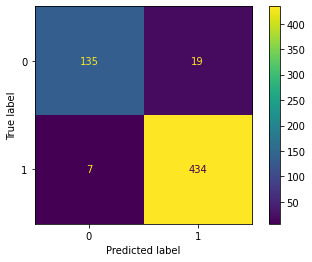

In [37]:
disp.plot()


### Setfit Few Shot-v2

In [ ]:
!python -m pip install git+https://github.com/huggingface/setfit.git

In [3]:
# !pip install setfit -q

In [7]:
from datasets import Dataset

In [8]:
complete_df = pd.read_csv('../data/labeled_data/labeled_data_v0.csv')

In [9]:
train_df, test_df = train_test_split(complete_df, test_size=0.4)

In [11]:
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer, sample_dataset

If error raises, run in the terminal: 

`export HF_DATASETS_CACHE=~/Desktop/MLOpsBootcamp/MLOpsCapstoneProject`

`TRANSFORMERS_CACHE=~/Desktop/MLOpsBootcamp/MLOpsCapstoneProject`

In [12]:
train_df.head()

,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,body,spam,body_transformed
1195,<22711056.1075861059308.JavaMail.evans@thyme>,2002-02-20 17:01:00,"""alan.aronowitz@enron.com""","""sara.shackleton@enron.com""","FW: EGM in the money, terminated counterparties",NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,"Aronowitz, Alan </O=ENRON/OU=NA/CN=RECIPIENTS/...","Shackleton, Sara </O=ENRON/OU=NA/CN=RECIPIENTS...",NaN,NaN,"\Sara_Shackleton_Mar2002\Shackleton, Sara\Inbox",Shackleton-S,sshackl (Non-Privileged).pst,"FYI. -----Original Message-----From: Smida, Ed...",0,FYI -----original Message-----From Smida Ed ...
1450,<30278242.1075854586659.JavaMail.evans@thyme>,2000-11-17 01:18:00,"""eric.ass@enron.com""","""rian.hoskins@enron.com""",Re: Keneally's,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,Eric Bass,Brian Hoskins,NaN,NaN,\Eric_Bass_Dec2000\Notes Folders\All documents,Bass-E,ebass.nsf,i'm not a big prince fan - she might want to t...,0,big prince fan want thoughbrian Hoskins@ENRON ...
839,<11846482.1075860755450.JavaMail.evans@thyme>,2002-01-31 23:35:45,"[""info@pmaconference.com""]","[""darrell.schoolcraft@enron.com""]",Managing the Risks of Retail Operations Feb 2...,NaN,1.0,text/plain; charset=us-ascii,quoted-printable,NaN,The Power Marketing Association <info@pmaconfe...,"Schoolcraft, Darrell </O=ENRON/OU=NA/CN=RECIPI...",NaN,NaN,"\Darrell_Schoolcraft_Mar2002\Schoolcraft, Darr...",Schoolcraft-D,dschool (Non-Privileged).pst,[IMAGE]=09[IMAGE] [IMAGE]=09=09 Managing the R...,1,image]=09[image image]=09=09 manage Risks Reta...
34,<17879251.1075860941512.JavaMail.evans@thyme>,2002-01-28 06:30:59,"[""angela.white@enron.com""]","[""dennis.lee@enron.com"", ""michael.odnar@enron....",RE: Credit request Oneok Bushton Processing,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,"White, Angela </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Lee, Dennis </O=ENRON/OU=NA/CN=RECIPIENTS/CN=D...",NaN,NaN,"\Lindy_Donoho_Mar2002_1\Donoho, Lindy\Inbox\Ju...",Donoho-L,ldonoho (Non-Privileged).pst,"Approved -----Original Message-----From: Lee, ...",1,approve -----original Message-----From Lee Den...
1384,<19949542.1075858836683.JavaMail.evans@thyme>,2001-10-25 10:35:00,"""gina.taylor@enron.com""","""shelley.corman@enron.com""",Slides per your request,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,"Taylor, Gina </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","Corman, Shelley </O=ENRON/OU=NA/CN=RECIPIENTS/...",NaN,NaN,\SCORMAN (Non-Privileged)\Deleted Items,Corman-S,SCORMAN (Non-Privileged).pst,Let me know if you need additional information...,0,let know need additional information Gina


In [17]:
_train_df = train_df[['body_transformed', 'spam']].sample(30)
_test_df = test_df[['body_transformed', 'spam']].sample(30)

In [20]:


# Simulate the few-shot regime by sampling 8 examples per class
train_dataset = Dataset.from_pandas(_train_df)
eval_dataset = Dataset.from_pandas(_test_df)


In [21]:
# Load a SetFit model from Hub
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2", cache_dir='~/Desktop/MLOpsBootcamp/MLOpsCapstoneProject')


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [22]:
# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, 
    num_epochs=1, 
    column_mapping={"body_transformed": "text", "spam": "label"} 
    
)


In [23]:
# Train and evaluate
trainer.train()


Applying column mapping to training dataset
***** Running training *****
  Num examples = 1200
  Num epochs = 1
  Total optimization steps = 75
  Total train batch size = 16
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Train and evaluate

metrics = trainer.evaluate()

NameError: name 'trainer' is not defined

In [3]:

# # Push model to the Hub
# trainer.push_to_hub("my-v1-setfit-model")

# Download from Hub and run inference
model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")

# Run inference

NameError: name 'SetFitModel' is not defined